In [1]:
from matplotlib import pyplot as plt
from rnaseq3 import RNAseq as RNAseq3
from os.path import expanduser as exusr
from CellModels.Cells.IO import CellReader
from CellModels.Cells.Filters import Masks
from CellModels.Clustering.IO import ClusteringReader
import numpy as np
import pandas as pd
import logging

%load_ext autoreload                                                                              
%autoreload 2

logging.basicConfig(level=logging.ERROR)

In [2]:
aerts_seq = RNAseq3(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/contrib/scRNAseq/EyeAntennal_Combined_DG2_v4.csv'))
ariss_seq = RNAseq3(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/contrib/GSE115476_RAW/GSM3178869_DMS.expr.txt'))
aerts = aerts_seq.data
ariss = ariss_seq.data


In [3]:
clustered = ClusteringReader.read(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/processing/clustering/bigc100k6n20r1000_metadata.yml'))
clustered.cells

m = Masks(clustered.cells)

In [4]:
c = clustered.cells
genes = c.genes
cluster_names = {
    1: 'R8 ato(+)',
    2: 'MF ato(+++)',
    3: 'peripodial',
    4: 'posterior',
    5: 'anterior',
    6: 'MF ato(+)',
    7: 'non-R8'
}

c.loc[m.cells_mf_area & (c[('Cluster', 'ward', 6)] == 4), ['Cluster']] = 7

c[('Cluster', 'ward', 6)].unique()

array([4., 6., 3., 7., 5., 2., 1.])

# Rescaling imaging and scRNAseq datasets

In [5]:
from scipy.stats import zscore

gcv = c.set_index(('Cluster', 'ward', 6), append=True) \
    .droplevel('Sample') \
    .rename_axis(index={('Cluster', 'ward', 6): 'Cluster'}) \
    .reorder_levels(['Gene', 'Cluster', 'Nucleus']) \
    .rename(columns={('Measurements', 'Normalized', 'Venus'): 'Normalized'}) \
    .sort_index() \
    .sort_index(axis='columns') \
    .xs(('Measurements', 'Normalized'), axis='columns', drop_level=True) \
    .loc[:, ['Venus']]
gcv['Zscore'] = np.nan

z_aerts = pd.DataFrame()
z_ariss = pd.DataFrame()

for gene in c.genes:
    gcv.loc[gene, 'Zscore'] = zscore(np.log2(gcv.loc[gene, 'Venus'] + 1))
    try:
        z_aerts[gene] = zscore(np.log2(aerts[gene] + 1))
    except KeyError:
        z_aerts[gene] = np.nan
    try:
        z_ariss[gene] = zscore(np.log2(ariss[gene] + 1))
    except KeyError:
        z_ariss[gene] = np.nan

In [6]:
import matplotlib.pyplot as plt

gcv.index.unique('Cluster')

Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype='float64', name='Cluster')

In [7]:
genes = []
for gene in c.genes:
    if gene in aerts.columns or gene in ariss.columns:
        genes.append(gene)
if len(genes) % 2 != 0:
    genes.append(None)

/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


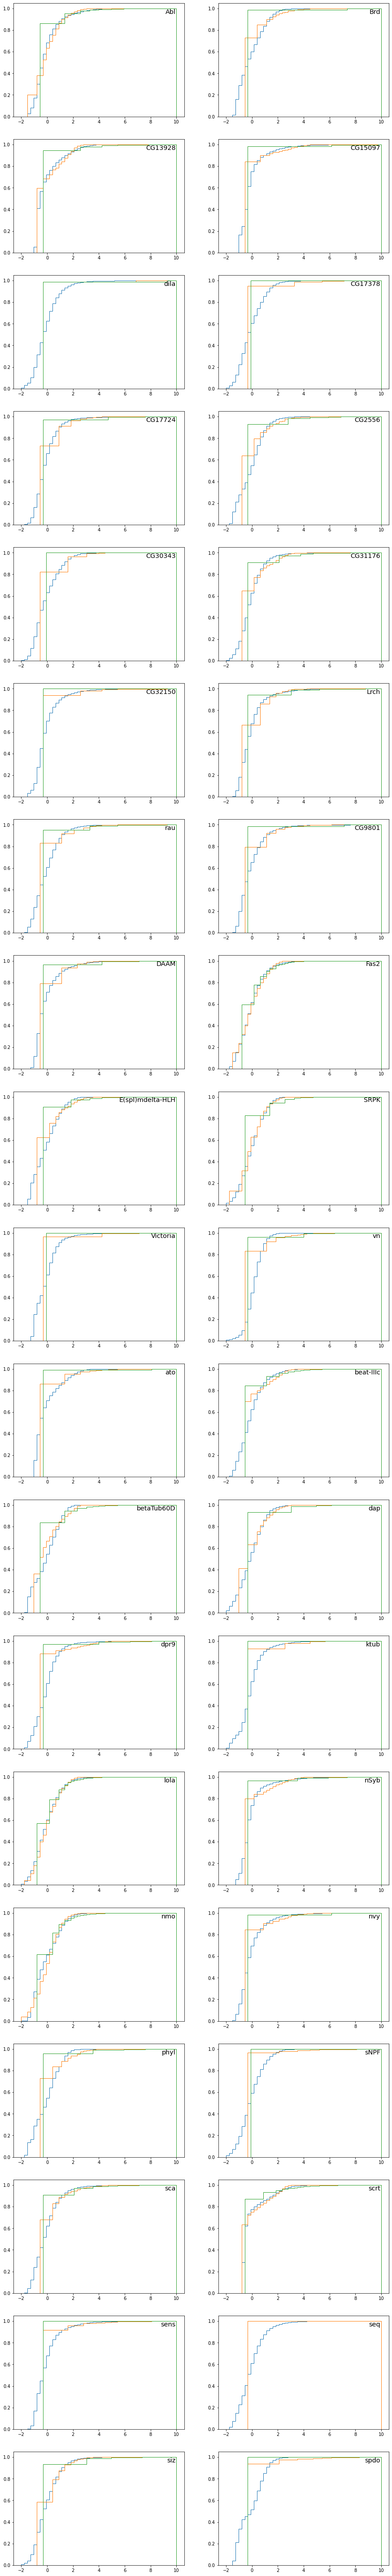

In [8]:
import math
from scipy.stats import ks_2samp

def expression_histogram(gene, show=False, ax=None, bins=20):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    ax.hist(gcv.loc[gene, 'Zscore'], bins=bins, color='C0', histtype='step', density=True, cumulative=True, range=(-2, 10))
    ax.hist(z_aerts[gene], bins=bins, color='C1', histtype='step', density=True, cumulative=True, range=(-2, 10))
    ax.hist(z_ariss[gene], bins=bins, color='C2', histtype='step', density=True, cumulative=True, range=(-2, 10))

    txt = gene    
    ax.text(0.95, 0.95, txt,
        horizontalalignment='right',
        verticalalignment='top',
        fontsize='x-large',
        transform=ax.transAxes)
    
    if show:
        fig.show()
    return fig

fig, axs = plt.subplots(math.ceil(len(genes) / 2), 2, figsize=(15, 105))
for gene, ax in zip(genes, axs.flatten()):
    if gene is not None:
        f = expression_histogram(gene, ax=ax, bins=50)


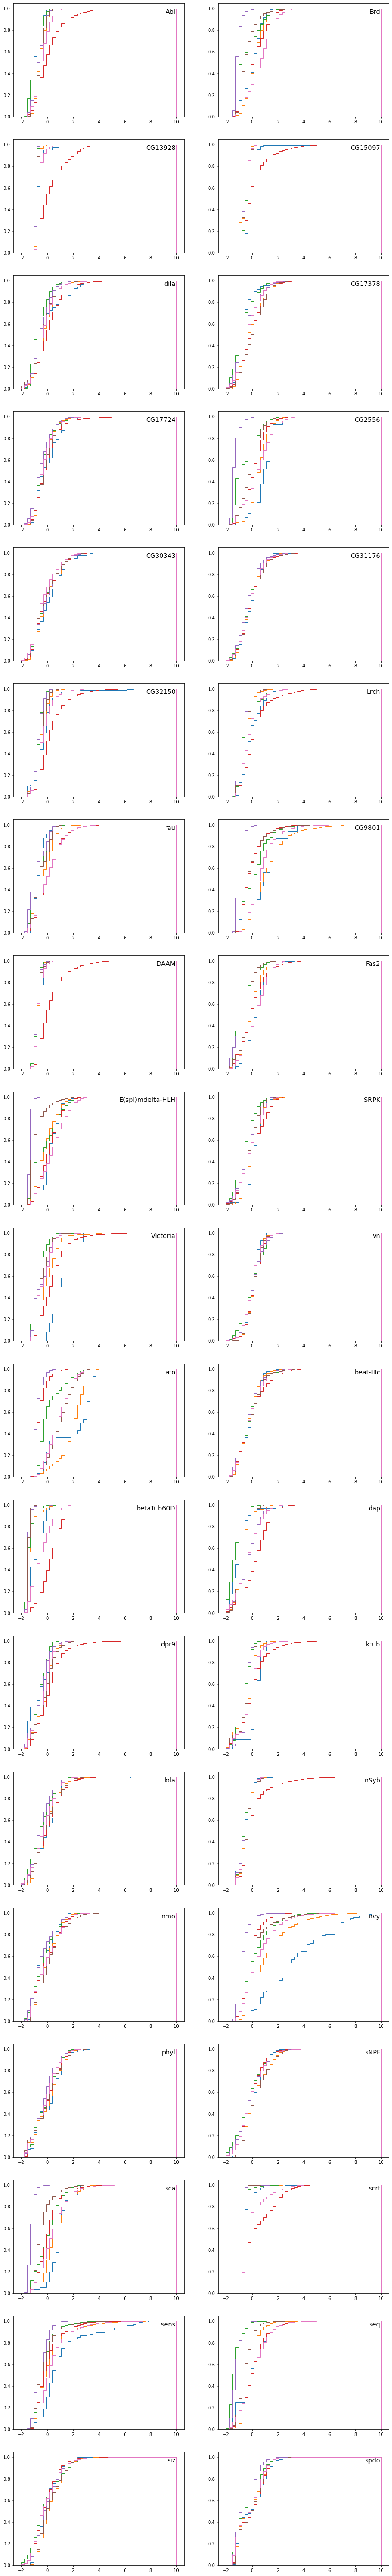

In [9]:
def class_histogram(gene, show=False, ax=None, bins=20):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    for cluster in gcv.index.unique('Cluster'):
        color = 'C' + str(int(cluster - 1))
        ax.hist(gcv.loc[(gene, cluster), 'Zscore'], bins=bins, color=color, histtype='step', density=True, cumulative=True, range=(-2, 10))

    txt = gene
    
    ax.text(0.95, 0.95, txt,
        horizontalalignment='right',
        verticalalignment='top',
        fontsize='x-large',
        transform=ax.transAxes)
    
    if show:
        fig.show()
    return fig

fig, axs = plt.subplots(math.ceil(len(c.genes) / 2), 2, figsize=(15, 105))
for gene, ax in zip(c.genes, axs.flatten()):
    if gene is not None:
        f = class_histogram(gene, ax=ax, bins=50)


# Mapping scRNAseq onto imaging classes

In [10]:
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad_vec

from CellModels.Cells.Filters import QC
from CellModels.Cells.Tools import CleanUp

excluded = [CleanUp.SYNONYMS[x] if x in CleanUp.SYNONYMS else x for x in QC.GENES_BAD]
excluded.append('seq')

densities = {}
genes2 = []
for gene in genes:
    if gene in excluded:
        continue
    else:
        genes2.append(gene)
        densities[gene] = {}
        for cl in gcv.index.unique('Cluster'):
            densities[gene][cl] = KernelDensity(kernel='gaussian', bandwidth=0.25) \
                .fit(gcv.loc[(gene, cl), 'Zscore'].values.reshape(-1, 1))
            

In [11]:
from scipy.integrate import quad

def map_sc_seq(ds):
    vals = np.ones((ds.shape[0], len(gcv.index.unique('Cluster'))))
    for gene in genes2:
        for j, c in enumerate(gcv.index.unique('Cluster')):
            cache = {}
            for i, v in enumerate(ds[gene]):
                if not v in cache:
                    cache[v] = quad(lambda x: np.exp(densities[gene][c].score_samples([[x]])), v-0.125, v+0.125)[0]
                vals[i][j] = vals[i][j] * cache[v]

    return np.argmax(vals, axis=1)


In [12]:
aerts['Cluster'] = map_sc_seq(z_aerts) + 1.0
z_aerts['Cluster'] = aerts['Cluster'].values
aerts['Cluster'].unique()

array([6., 7., 4., 3., 5., 2., 1.])

In [13]:
ariss['Cluster'] = map_sc_seq(z_ariss) + 1.0
z_ariss['Cluster'] = ariss['Cluster'].values
ariss['Cluster'].unique()

array([4., 1., 7., 2., 6.])

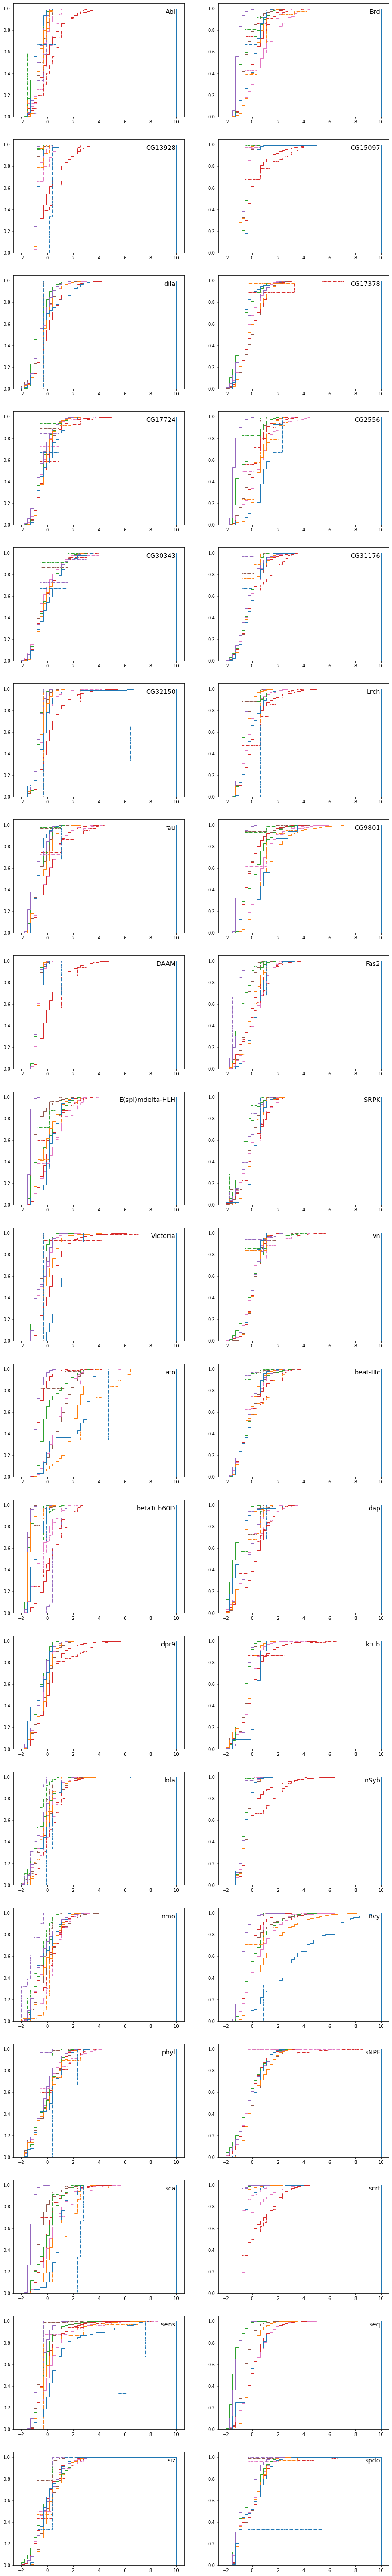

In [14]:
def mapped_histogram(df, gene, show=False, ax=None, bins=20):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    for cluster in df['Cluster'].unique():
        color = 'C' + str(int(cluster - 1.0))
        cs = df['Cluster'] == cluster
        ax.hist(df.loc[cs, gene], bins=bins, color=color, histtype='step', density=True, cumulative=True, range=(-2, 10), ls='-.')
        ax.hist(gcv.loc[(gene, cluster), 'Zscore'], bins=bins, color=color, histtype='step', density=True, cumulative=True, range=(-2, 10))

    txt = gene
    
    ax.text(0.95, 0.95, txt,
        horizontalalignment='right',
        verticalalignment='top',
        fontsize='x-large',
        transform=ax.transAxes)
    
    if show:
        fig.show()
    return fig

fig, axs = plt.subplots(math.ceil(len(c.genes) / 2), 2, figsize=(15, 105))
for gene, ax in zip(c.genes, axs.flatten()):
    if gene is not None:
        f = mapped_histogram(z_aerts, gene, ax=ax, bins=50)


/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/numpy/lib

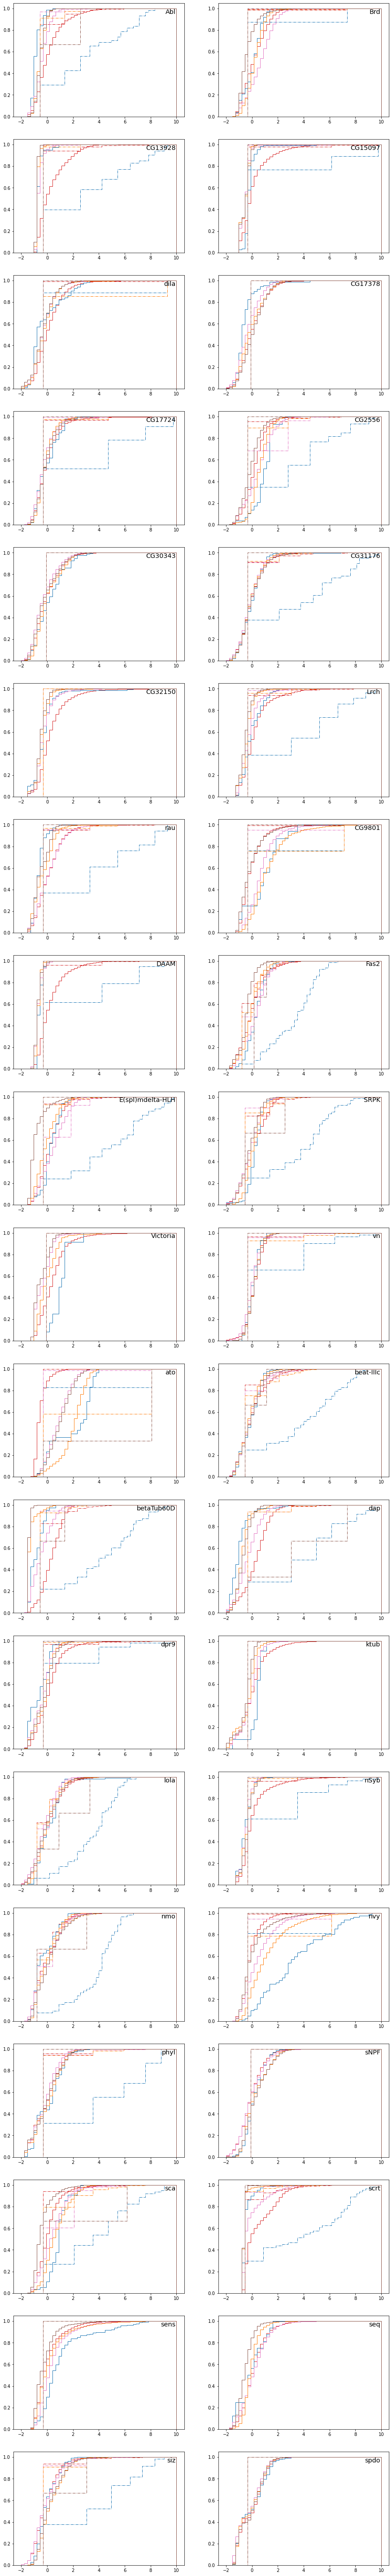

In [15]:
fig, axs = plt.subplots(math.ceil(len(c.genes) / 2), 2, figsize=(15, 105))
for gene, ax in zip(c.genes, axs.flatten()):
    if gene is not None:
        f = mapped_histogram(z_ariss, gene, ax=ax, bins=50)

# Clustering Heatmap

In [16]:
m_aerts = np.log2((aerts.drop(['Unnamed: 0', 'Cluster'], axis=1) + 1).mean())
h_aerts = np.log2((aerts.drop(['Unnamed: 0'], axis=1) + 1).groupby('Cluster').mean())
h_aerts.index = h_aerts.index - 1
h_aerts = h_aerts - m_aerts
h_aerts

,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40596,28SrRNA-Psi:CR40741,28SrRNA-Psi:CR41609,...,z,zetaCOP,zf30C,zfh1,zfh2,zip,zld,zormin,zuc,zyd
Cluster,,,,,,,,,,,,,,,,,,,,,
1.0,-0.608789,-0.197853,-0.011319,-0.686301,-0.088104,-0.355405,-1.546541,-0.170598,-0.032341,-0.003629,...,-0.355689,0.203588,-0.862110,-0.908747,1.090559,-0.479607,0.755601,0.290032,0.250371,-0.036480
2.0,-0.364864,-0.413359,-0.406576,-0.126873,0.021520,0.505191,-0.433402,0.040906,-0.032341,-0.003629,...,-0.087917,-0.014592,-0.150036,-0.908747,-0.006060,-0.562628,0.262561,-0.235430,-0.020276,-0.036480
3.0,-0.345755,-0.997693,-0.912293,-0.239899,-0.019981,-0.502134,-0.435509,-0.046124,-0.010314,-0.003629,...,-0.383704,-0.601918,-0.455819,-0.157269,-0.564623,-0.860697,-0.841186,-0.157716,-0.054810,-0.002017
4.0,0.085466,0.331969,0.310139,0.083945,-0.002576,-0.065014,0.145356,-0.000819,0.000168,0.001622,...,0.143946,0.199857,0.153423,0.174300,0.145445,0.298329,0.121062,0.056417,-0.012532,-0.005258
5.0,-0.349403,-0.772420,-0.603827,-0.115985,-0.045035,-0.710500,0.660784,-0.127529,0.010728,-0.003629,...,-0.388856,0.000497,-0.514187,1.593754,-0.783911,0.441783,-1.810745,-0.403865,0.000393,-0.036480
6.0,-0.150359,-0.453274,-0.495952,-0.097672,0.004317,-0.066900,-0.320691,0.011917,0.000325,0.003694,...,-0.189440,-0.355002,-0.223108,-0.549852,-0.088715,-0.514440,-0.195825,-0.131629,0.001583,0.006912
7.0,0.305237,0.263696,0.303909,0.138549,0.030122,0.626598,0.265236,0.053497,0.014580,-0.003629,...,0.186927,0.280335,0.259316,-0.068277,0.237785,0.259741,0.550984,0.188792,0.099692,0.018115


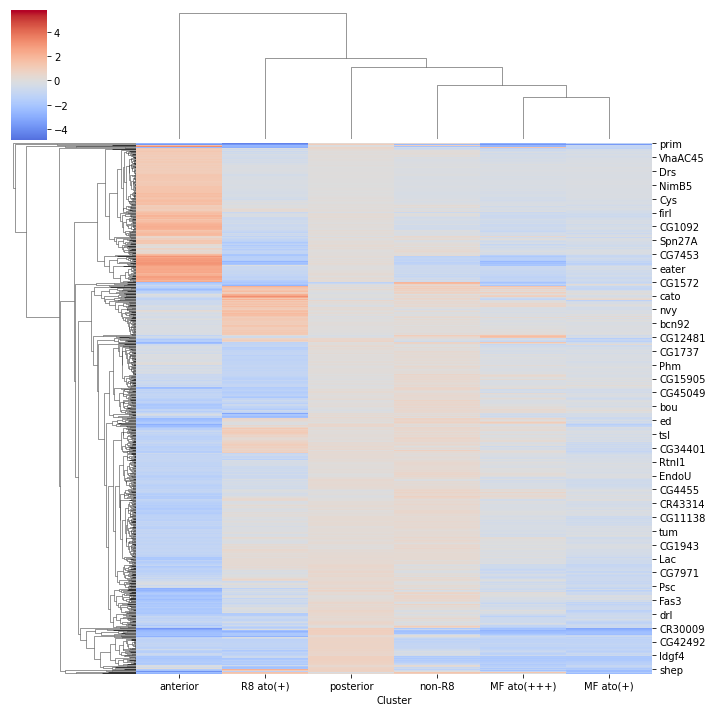

In [18]:
import seaborn as sns
g = sns.clustermap(h_aerts.rename(cluster_names) \
                          .drop('peripodial') \
                          .drop(h_aerts.columns[h_aerts.abs().max(axis='rows') < 1], axis='columns') \
                          .transpose(), cmap="coolwarm", center=0)

In [19]:
cluster_names

{1: 'R8 ato(+)',
 2: 'MF ato(+++)',
 3: 'peripodial',
 4: 'posterior',
 5: 'anterior',
 6: 'MF ato(+)',
 7: 'non-R8'}

In [20]:
m_ariss = np.log2((ariss.drop(['Cluster'], axis=1) + 1).mean())
h_ariss = np.log2((ariss + 1).groupby('Cluster').mean())
h_ariss.index = h_ariss.index - 1
h_ariss = h_ariss - m_ariss
h_ariss

,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40741,28SrRNA-Psi:CR41609,28SrRNA-Psi:CR45855,...,snRNA:U1:95Cb,snoRNA:Me18S-A1597,tRNA:CR30298,tRNA:CR31497,tRNA:CR31895,tRNA:CR32093,tRNA:CR32286,tRNA:E4:62Ae,tRNA:M3:70Fb,tRNA:N5:42Ab
Cluster,,,,,,,,,,,,,,,,,,,,,
1.0,0.718644,3.687063,3.556353,0.174692,2.547823,0.671012,1.362283,1.186836,0.585492,1.413545,...,-0.000060,-0.000060,-0.000060,-0.000120,0.022308,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060
2.0,0.032963,0.112405,0.047376,-0.000633,0.130697,0.051639,0.026658,0.044139,0.044422,-0.159544,...,-0.000060,-0.000060,-0.000060,-0.000120,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060
4.0,-0.002870,-0.042711,-0.038415,-0.000175,-0.015405,-0.004473,-0.003038,-0.002304,-0.001721,0.004482,...,0.000007,0.000007,0.000007,0.000013,-0.000060,0.000007,0.000007,0.000007,0.000007,-0.000060
6.0,0.339265,1.914879,1.851651,-0.015132,0.831289,-0.083876,-0.176875,1.025524,0.314029,0.828582,...,-0.000060,-0.000060,-0.000060,-0.000120,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060
7.0,-0.006091,-0.130768,-0.108184,-0.004021,-0.091962,0.011092,-0.046828,-0.047247,-0.014421,-0.103929,...,-0.000060,-0.000060,-0.000060,-0.000120,-0.000060,-0.000060,-0.000060,-0.000060,-0.000060,0.000684


/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


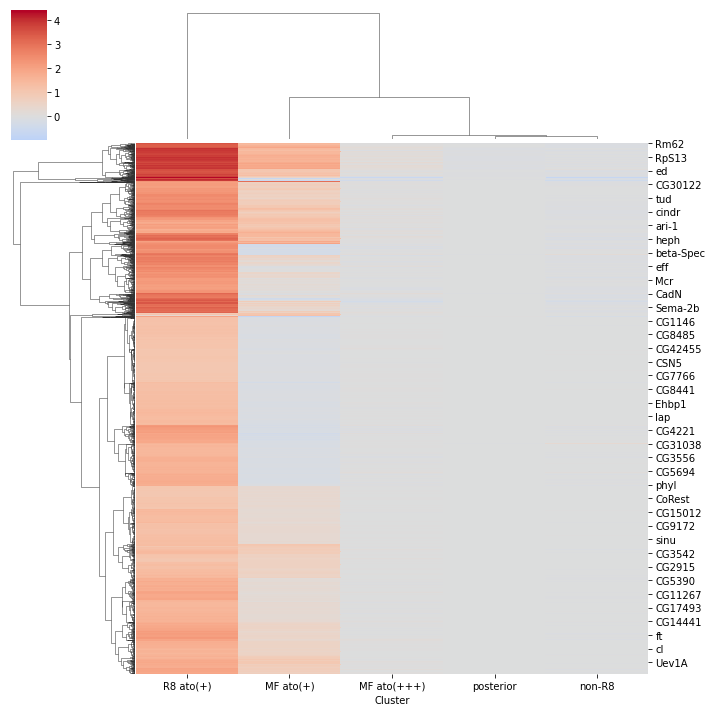

In [21]:
g = sns.clustermap(h_ariss.rename(cluster_names) \
                          .drop(h_ariss.columns[h_ariss.abs().max(axis='rows') < 1], axis='columns') \
                          .transpose(), cmap="coolwarm", center=0)

In [22]:
s_aerts = h_aerts.rename(cluster_names).transpose()
s_aerts

Cluster,R8 ato(+),MF ato(+++),peripodial,posterior,anterior,MF ato(+),non-R8
128up,-0.608789,-0.364864,-0.345755,0.085466,-0.349403,-0.150359,0.305237
14-3-3epsilon,-0.197853,-0.413359,-0.997693,0.331969,-0.772420,-0.453274,0.263696
14-3-3zeta,-0.011319,-0.406576,-0.912293,0.310139,-0.603827,-0.495952,0.303909
140up,-0.686301,-0.126873,-0.239899,0.083945,-0.115985,-0.097672,0.138549
18SrRNA-Psi:CR41602,-0.088104,0.021520,-0.019981,-0.002576,-0.045035,0.004317,0.030122
...,...,...,...,...,...,...,...
zip,-0.479607,-0.562628,-0.860697,0.298329,0.441783,-0.514440,0.259741
zld,0.755601,0.262561,-0.841186,0.121062,-1.810745,-0.195825,0.550984
zormin,0.290032,-0.235430,-0.157716,0.056417,-0.403865,-0.131629,0.188792
zuc,0.250371,-0.020276,-0.054810,-0.012532,0.000393,0.001583,0.099692


In [23]:
aerts.groupby('Cluster').count().rename(cluster_names)

,Unnamed: 0,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40596,28SrRNA-Psi:CR40741,...,z,zetaCOP,zf30C,zfh1,zfh2,zip,zld,zormin,zuc,zyd
Cluster,,,,,,,,,,,,,,,,,,,,,
R8 ato(+),3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
MF ato(+++),38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
peripodial,455,455,455,455,455,455,455,455,455,455,...,455,455,455,455,455,455,455,455,455,455
posterior,1097,1097,1097,1097,1097,1097,1097,1097,1097,1097,...,1097,1097,1097,1097,1097,1097,1097,1097,1097,1097
anterior,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
MF ato(+),393,393,393,393,393,393,393,393,393,393,...,393,393,393,393,393,393,393,393,393,393
non-R8,363,363,363,363,363,363,363,363,363,363,...,363,363,363,363,363,363,363,363,363,363


# GO enrichment analysis

In [24]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

In [25]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-10-09) 47,313 GO Terms


In [26]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[7227])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated Drosophila genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:02.725913 104,531 annotations, 13,701 genes,  8,616 GOs, 1 taxids READ: gene2go 
MF 9,170 annotated Drosophila genes
CC 9,539 annotated Drosophila genes
BP 10,499 annotated Drosophila genes


In [27]:
from genes_ncbi_7227_proteincoding import GENEID2NT as GeneID2nt_dmel
print(len(GeneID2nt_dmel))

13968


In [28]:
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_dmel.keys(),
        ns2assoc,
        obodag,
        propagate_counts = False,
        alpha = 0.05,
        methods = ['fdr_bh'])


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 69%  9,626 of 13,968 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 65%  9,082 of 13,968 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 63%  8,755 of 13,968 population items found in association


In [29]:
s_aerts[s_aerts['MF ato(+)'] > 0.5]

Cluster,R8 ato(+),MF ato(+++),peripodial,posterior,anterior,MF ato(+),non-R8
ss,2.119098,-1.05844,-0.518543,-0.211687,-1.112064,0.510022,0.493017


In [30]:
genesyms = list(s_aerts[s_aerts['MF ato(+)'] > 0.75].index)
geneids = [v.GeneID for v in GeneID2nt_dmel.values() if v.Symbol in genesyms]
goea_quiet_all = goeaobj.run_study(geneids, prt=None)
goea_quiet_sig = [r for r in goea_quiet_all if r.p_fdr_bh < 0.05]
plot_results("R8_ato_UP_{NS}.png", goea_quiet_sig)

In [31]:
genesyms = list(s_aerts[s_aerts['MF ato(+++)'] > 0.5].index)
geneids = [v.GeneID for v in GeneID2nt_dmel.values() if v.Symbol in genesyms]
goea_quiet_all = goeaobj.run_study(geneids, prt=None)
goea_quiet_sig = [r for r in goea_quiet_all if r.p_fdr_bh < 0.05]
plot_results("MF_ato_UP_{NS}.png", goea_quiet_sig)

    3 usr  27 GOs  WROTE: MF_ato_UP_BP.png
    1 usr   3 GOs  WROTE: MF_ato_UP_CC.png
    4 usr  22 GOs  WROTE: MF_ato_UP_MF.png


In [32]:
genesyms = list(s_aerts[s_aerts['MF ato(+)'] > 0.5].index)
geneids = [v.GeneID for v in GeneID2nt_dmel.values() if v.Symbol in genesyms]
goea_quiet_all = goeaobj.run_study(geneids, prt=None)
goea_quiet_sig = [r for r in goea_quiet_all if r.p_fdr_bh < 0.05]
plot_results("MF_UP_{NS}.png", goea_quiet_sig)

In [33]:
genesyms = list(s_aerts[s_aerts['MF ato(+)'] < 1].index)
geneids = [v.GeneID for v in GeneID2nt_dmel.values() if v.Symbol in genesyms]
goea_quiet_all = goeaobj.run_study(geneids, prt=None)
goea_quiet_sig = [r for r in goea_quiet_all if r.p_fdr_bh < 0.05]
plot_results("MF_DOWN_{NS}.png", goea_quiet_sig)

  319 usr 1027 GOs  WROTE: MF_DOWN_BP.png
   82 usr 141 GOs  WROTE: MF_DOWN_CC.png
   90 usr 237 GOs  WROTE: MF_DOWN_MF.png


In [34]:
aerts['Cluster'].to_csv('aerts_clusters.csv')

In [35]:
aerts['Cluster'].astype(int).astype(str).to_csv('aerts_clusters.csv')

In [36]:
aerts_seq

In [37]:
aerts.drop(columns=['Cluster', aerts.columns[0]]).to_csv('export/aerts_counts.csv')

In [38]:
aerts[['Cluster']].to_csv('export/aerts_clusters.csv')

In [39]:
aerts_orig = pd.read_csv(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/contrib/scRNAseq/Seurat_ead_dg2gg.matrix.tsv'), delimiter=' ')

In [40]:
aerts_orig

,AACCGCGGTTGAGTTC-1,AACGTTGCAATCACAC-1,AACTCCCGTTCTGGTA-1,AACTCCCTCCCAAGTA-1,AACTCCCTCTGCGTAA-1,AACTCTTGTCACTGGC-1,AACTGGTGTTACGGAG-1,AACTGGTTCCAATGGT-1,AACTTTCAGGATCGCA-1,AACTTTCCAGCCTTTC-1,...,TTTCCTCTCGTGGTCG-2,TTTCCTCTCTGCCCTA-2,TTTCCTCTCTTAGAGC-2,TTTGCGCCACATCCAA-2,TTTGCGCGTGCAACTT-2,TTTGGTTCAAGAAAGG-2,TTTGGTTTCTATCCTA-2,TTTGTCACAGCGATCC-2,TTTGTCAGTACCGGCT-2,TTTGTCAGTCGAGATG-2
Prosalpha2,1,0,3,2,0,0,4,6,2,2,...,4,9,22,4,5,2,4,5,18,4
CR45913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CG6724,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,1,2,0,0,0,0
Tsf3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
CG3253,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CG34309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR32252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR44617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GFP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
aerts_orig.sort_index().transpose().index.to_frame().set_index(aerts.index).to_csv('export/aerts_cells.csv')

In [42]:
c.genes.to_series().to_csv('export/genes.csv')

In [43]:
genes

['Abl',
 'Brd',
 'CG13928',
 'CG15097',
 'dila',
 'CG17378',
 'CG17724',
 'CG2556',
 'CG30343',
 'CG31176',
 'CG32150',
 'Lrch',
 'rau',
 'CG9801',
 'DAAM',
 'Fas2',
 'E(spl)mdelta-HLH',
 'SRPK',
 'Victoria',
 'vn',
 'ato',
 'beat-IIIc',
 'betaTub60D',
 'dap',
 'dpr9',
 'ktub',
 'lola',
 'nSyb',
 'nmo',
 'nvy',
 'phyl',
 'sNPF',
 'sca',
 'scrt',
 'sens',
 'seq',
 'siz',
 'spdo']

In [44]:
pd.DataFrame(cluster_names.values(), index=cluster_names.keys()).to_csv('export/clusters.csv')

In [45]:
c.to_csv('export/imaging_data.csv')

In [46]:
gcv.to_csv('export/imaging_zscores.csv')

In [47]:
gcv

Venus    Zscore
Gene Cluster Nucleus                    
Abl  1.0     74602    1.083439  0.496938
             75144    0.769613  0.014898
             75252    0.814949  0.089588
             75889    0.599878 -0.282826
             75892    0.624490 -0.237749
...                        ...       ...
vn   7.0     2126203  0.438615  1.722261
             2126204  0.410504  1.465168
             2126205  0.429245  1.637126
             2126206  0.327566  0.675672
             2126242  0.377907  1.160554

[2368709 rows x 2 columns]

In [48]:
z_aerts.drop(columns=['Cluster']).to_csv('export/aerts_zscores.csv')